In [1]:
import pandas as pd
from Bio import AlignIO
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr

In [2]:
kinases = pd.read_csv('../datasets/kinases.tsv', sep= '\t')
kinases.columns = kinases.columns.str.lower()

In [3]:
#path = '../homology_transfer/pipeline_MSA_uniprot/data_snake/09_align_selection/'

In [4]:
#align = AlignIO.read(open('../homology_transfer/pipeline_MSA_uniprot/data_snake/09_align_selection/P00519_clustalO_fullidentity_all.fasta.aln'), format= 'fasta')
#len(align) # hacer una distribucion

# Distribution seqs/MSA

In [5]:
def seqs_per_msa(path):
    '''
    returns a DataFrame with number of sequences in each MSA
    path: path to folder containing MSA files
    '''
    # iterate over the MSA files
    seqs_msa = {}
    l = []
    no_errors = 0
    i = 0
    for filename in os.listdir(path):
        f = os.path.join(path, filename) # is the complete path to each msa

        if os.path.isfile(f):
            
            # Check if file is empty
            check_file = os.stat(f).st_size
            if check_file != 0:
                msa_name = filename.split(".")[0].split("_")
                msa_name = msa_name[0] + "_" + msa_name[3]
                # align objects can be treated as lists of SeqRecord objects
                align = AlignIO.read(open(f), format= 'fasta')
                for record in align:
                    try:
                        l.append([msa_name, record.id, len(record)])
                        #print("%s %i" % (record.id, len(record)))
                        seqs_msa[msa_name] = len(align)
                        # to dataframe
                        
                        i += 1
                    except:
                        print(f"error in file {filename}")
                        no_errors += 1
    df = pd.DataFrame.from_dict(seqs_msa, orient= 'index').reset_index().rename(columns= {'index': 'msa', 0: 'no_seqs'})
    return df, l

In [6]:
# df no. of seqs per MSA
seqs_msa, l = seqs_per_msa(path= '../homology_transfer/pipeline_MSA_uniprot/data_snake/09_align_selection/')
seqs_msa

,msa,no_seqs
0,A0A2I0BVG8_60,6
1,A0A2I0BVG8_80,5
2,A0A2I0BVG8_all,45
3,A0A509AFG4_60,6
4,A0A509AFG4_80,2
...,...,...
744,Q9ZV15_80,3
745,Q9ZV15_all,77
746,W7JX98_60,5
747,W7JX98_80,5


<AxesSubplot:>

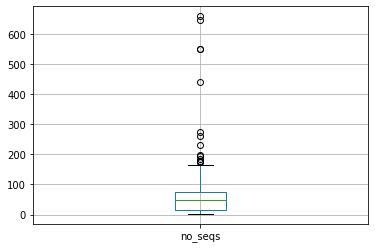

In [7]:
seqs_msa.boxplot()

In [8]:
def plot_distrib_msa(data, threshold= 'all'):
    threshold = str(threshold)
    data[data.msa.str.endswith(threshold)].no_seqs.plot(kind= 'hist', bins= 50, color= 'gray', edgecolor= 'black')
    plt.title(f"Distribution #seqs/MSA\nthreshold = {threshold}")
    plt.ylabel("# MSAs")
    plt.xlabel('# sequences')
    plt.show()

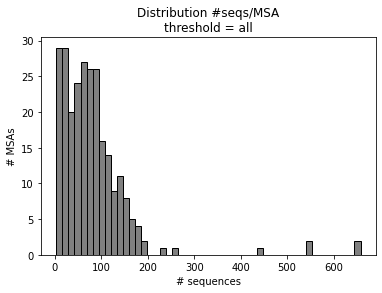

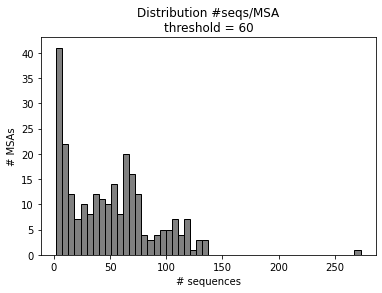

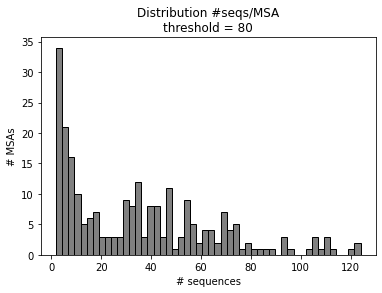

In [9]:
plot_distrib_msa(data= seqs_msa)
plot_distrib_msa(data= seqs_msa, threshold=60)
plot_distrib_msa(data= seqs_msa, threshold=80)

In [10]:
len(seqs_msa[(seqs_msa.msa.str.endswith("all")) & (seqs_msa.no_seqs >= 100)])

70

In [11]:
len(seqs_msa[(seqs_msa.msa.str.endswith("60")) & (seqs_msa.no_seqs >= 100)])

31

In [12]:
len(seqs_msa[(seqs_msa.msa.str.endswith("80")) & (seqs_msa.no_seqs >= 100)])

12

# Orthologs overlap

In [13]:
all_msas = pd.DataFrame(l, columns= ['msa', 'uniprot', 'length_msa'])
all_msas

,msa,uniprot,length_msa
0,A0A2I0BVG8_60,A0A2I0BVG8,536
1,A0A2I0BVG8_60,A0A0D9QJY8,536
2,A0A2I0BVG8_60,A0A0L7M8D5,536
3,A0A2I0BVG8_60,A0A1Y3DU95,536
4,A0A2I0BVG8_60,A5KBU9,536
...,...,...,...
42143,W7JX98_all,R7TJP2,1377
42144,W7JX98_all,T1J2D2,1377
42145,W7JX98_all,U3KFF9,1377
42146,W7JX98_all,W2SK18,1377


In [47]:
#all_msas.to_csv('../datasets/all_msas.tsv', sep= '\t', index= False)

In [15]:
# Subset the MSAs
all = all_msas[all_msas.msa.str.endswith("all")]
msa_60 = all_msas[all_msas.msa.str.endswith("60")]
msa_80 = all_msas[all_msas.msa.str.endswith("80")]

In [16]:
# list with kinases reference proteins
kin = kinases.uniprot.unique().tolist()

In [17]:
# Create sets with unique proteins in each msa
all = all.groupby("msa").agg({'uniprot': lambda x: x.tolist()}).reset_index()
all

,msa,uniprot
0,A0A2I0BVG8_all,"[A0A2I0BVG8, A0A023B173, A0A0C2IKB7, A0A0D9QJY..."
1,A0A509AFG4_all,"[A0A509AFG4, A0A015KQ67, A0A059J0T9, A0A0D9QSD..."
2,A0A509AHB6_all,"[A0A509AHB6, A0A023B173, A0A0C2IKB7, A0A0D2VHA..."
3,A0A509AKL0_all,"[A0A509AKL0, A0A023B252, A0A061DD08, A0A068Y9V..."
4,A0A509AQE6_all,"[A0A509AQE6, A0A015K587, A0A023BCV0, A0A061DD0..."
...,...,...
252,Q9ZSA3_all,"[Q9ZSA3, A0A087GM80, B6EP77, G8JN52, K5BI95, M..."
253,Q9ZSA4_all,"[Q9ZSA4, A0A0L8ICP1, A0A668RKR5, A3DEI9, C4Y9R..."
254,Q9ZUZ2_all,"[Q9ZUZ2, A0A059C0N6, A0A061CZ84, A0A061DU80, A..."
255,Q9ZV15_all,"[Q9ZV15, A0A059DJ09, A0A068UQL6, A0A087H3U3, A..."


In [18]:
def find_overlaps(df, refers):
    '''
    df: dataframe containing MSAs and list of proteins in each one
    refers: list containing reference proteins for checking overlap
    returns dataframe with MSA name, list of proteins in that MSA and list of reference
    proteins in that MSA
    '''
    # Create lists with proteins in each msa
    df = df.groupby("msa").agg({'uniprot': lambda x: x.tolist()}).reset_index()
    df["overlap"] = [ [] for _ in range(len(df))]
    for ix in df.index:
        lst = df.uniprot[ix][1:] # exclude the first because is the reference
        for kinase in refers:
            if kinase in lst:
                df["overlap"][ix].append(kinase)
    return df

In [19]:
# Ok. tested
def plot_overlap(msa, refers, title, color= 'royalblue', bins= 6):
    '''
    plot overlaping reference proteins in MSAs 
    '''
    df = find_overlaps(msa, refers)
    df.overlap.apply(lambda x: len(x)).plot(
    kind= 'hist',
    color= color,
    edgecolor= 'black',
    bins= bins
    )
    plt.title(title)
    plt.xlabel("# proteins")
    plt.show()


### Plots overlap

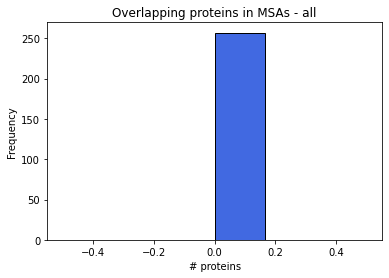

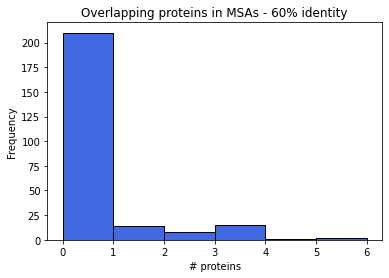

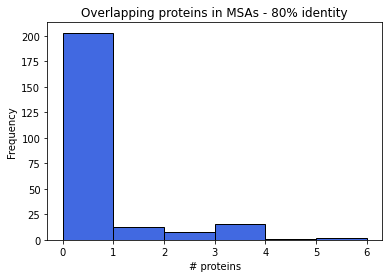

In [20]:
plot_overlap(all, refers= kin, title= "Overlapping proteins in MSAs - all")
plot_overlap(msa_60, refers= kin, title= "Overlapping proteins in MSAs - 60% identity")
plot_overlap(msa_80, refers= kin, title= "Overlapping proteins in MSAs - 80% identity")

---

# Mapping PDBs to orthologs 

In [21]:
sift = pd.read_csv(
    '../datasets/uniprot_segments_observed.tsv.gz',
    sep= '\t',
    compression= 'gzip',
    skiprows= 1
)
sift.columns = sift.columns.str.lower()

In [22]:
sift

,pdb,chain,sp_primary,res_beg,res_end,pdb_beg,pdb_end,sp_beg,sp_end
0,121p,A,P01112,1,166,1,166,1,166
1,132l,A,P00698,1,129,1,129,19,147
2,133l,A,P61626,1,130,1,130,19,148
3,129l,A,P00720,1,162,1,162,1,162
4,139l,A,P00720,1,162,1,162,1,162
...,...,...,...,...,...,...,...,...,...
977668,6e9d,v,P03135,226,735,226,735,226,735
977669,6e9d,w,P03135,226,735,226,735,226,735
977670,6e9d,x,P03135,226,735,226,735,226,735
977671,6e9d,y,P03135,226,735,226,735,226,735


In [23]:
pdb_uniprot_map = sift[['pdb', 'sp_primary']].drop_duplicates().rename(columns= 
    {
    'sp_primary': 'uniprot',
    'sp_beg': 'start',
    'sp_end': 'end'    
    }
)
pdb_uniprot_map

,pdb,uniprot
0,121p,P01112
1,132l,P00698
2,133l,P61626
3,129l,P00720
4,139l,P00720
...,...,...
977587,6eae,P03420
977589,6e9p,P9WFY1
977591,6e9p,P9WFX9
977601,6eaf,P03420


In [24]:
# Mapping: pdbs for each uniprot
pdb_uniprot = sift[['pdb', 'sp_primary', 'chain', 'sp_beg', 'sp_end']].drop_duplicates().rename(columns= 
    {
    'sp_primary': 'uniprot_acc',
    'sp_beg': 'start',
    'sp_end': 'end'    
    }
)
pdb_uniprot

,pdb,uniprot_acc,chain,start,end
0,121p,P01112,A,1,166
1,132l,P00698,A,19,147
2,133l,P61626,A,19,148
3,129l,P00720,A,1,162
4,139l,P00720,A,1,162
...,...,...,...,...,...
977668,6e9d,P03135,v,226,735
977669,6e9d,P03135,w,226,735
977670,6e9d,P03135,x,226,735
977671,6e9d,P03135,y,226,735


In [25]:
# Get list of orthologs
ortho = all_msas.uniprot.unique().tolist()

In [26]:
len(ortho)

13652

In [27]:
# Save it
# with open('../datasets/all_orthologs.txt', 'w') as f:
#     for protein in ortho:
#         f.write(f"{protein}\n")

### How many orthologs proteins have pdb structure

In [28]:
# How many orthologs proteins have pdb structure
pdb_orthologs = pdb_uniprot[pdb_uniprot.uniprot_acc.isin(ortho)]
pdb_orthologs

,pdb,uniprot_acc,chain,start,end
965,1gag,P06213,A,1008,1310
1044,1gzo,P31751,A,146,188
1045,1gzo,P31751,A,198,296
1046,1gzo,P31751,A,313,442
1234,1i35,P28829,A,71,165
...,...,...,...,...,...
977457,7up8,O75582,B,559,574
977458,7up8,O75582,B,600,624
977459,7up8,O75582,B,630,727
977487,7pi4,Q05397,DDD,415,573


In [29]:
f"{pdb_orthologs.uniprot_acc.nunique()} out of {len(ortho)} ortholog proteins have {pdb_orthologs.pdb.nunique()} PDB structure"

'126 out of 13652 ortholog proteins have 2157 PDB structure'

In [30]:
# estas 2157 estructuras corresponden a todas las secuencias ortologas, 
# es decir, estan distribuidas en todos los MSAs

In [45]:
# # Check with uniprotKB advance search
# ortho_uniprot = pd.read_csv('../raw_data/orthologs-uniprot-structure-2022.11.18-20.00.24.25.tsv.gz', sep= '\t', compression= 'gzip')
# ortho_uniprot.info() # 127 proteins with 3D structures, ok! 

In [32]:
# Buscar de esta lista de 126 proteinas, cuales son de referencia en MSAs
all["reference"] = all.msa.apply(lambda x: x.split("_")[0])

In [33]:
all[all.reference.isin(pdb_orthologs.uniprot_acc)]

,msa,uniprot,reference
9,A5K0N4_all,"[A5K0N4, A0A023B252, A0A061DD08, A0A090LL98, A...",A5K0N4
14,O14757_all,"[O14757, A0A010QQY9, A0A017SJY9, A0A026WMA8, A...",O14757
17,O43318_all,"[O43318, A0A015KBU3, A0A023BBL1, A0A026W016, A...",O43318
19,O74536_all,"[O74536, A0A010REC8, A0A015NFB9, A0A023B5H0, A...",O74536
20,O75582_all,"[O75582, A0A060W937, A0A087YI90, A0A091CKQ0, A...",O75582
...,...,...,...
230,Q9H4A3_all,"[Q9H4A3, A0A084QN01, A0A087XNA6, A0A0D9RGY6, A...",Q9H4A3
231,Q9JIH7_all,"[Q9JIH7, A0A058ZEP2, A0A087XNA6, A0A0N1I038, A...",Q9JIH7
236,Q9NJU9_all,"[Q9NJU9, A0A0D9QSD5, A0A0L7M6Y1, A0A1A8B2I9, A...",Q9NJU9
246,Q9UIK4_all,"[Q9UIK4, A0A067CHY9, A0A096LS66, A0A0B2V584, A...",Q9UIK4


In [34]:
# Buscar de esta lista de 126 proteinas, cuales son de referencia en MSAs
msa_60["reference"] = msa_60.msa.apply(lambda x: x.split("_")[0])
msa_60[msa_60.reference.isin(pdb_orthologs.uniprot_acc)]

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,msa,uniprot,length_msa,reference
518,A5K0N4_60,A5K0N4,923,A5K0N4
519,A5K0N4_60,A0A023B252,923,A5K0N4
520,A5K0N4_60,A0A0D9QPF1,923,A5K0N4
521,A5K0N4_60,A0A0L7M3I6,923,A5K0N4
522,A5K0N4_60,B6K8K4,923,A5K0N4
...,...,...,...,...
41175,Q9Y243_60,U3IVJ2,584,Q9Y243
41176,Q9Y243_60,U3KAB4,584,Q9Y243
41177,Q9Y243_60,W5K689,584,Q9Y243
41178,Q9Y243_60,W5NE85,584,Q9Y243


In [35]:
msa_60

,msa,uniprot,length_msa,reference
0,A0A2I0BVG8_60,A0A2I0BVG8,536,A0A2I0BVG8
1,A0A2I0BVG8_60,A0A0D9QJY8,536,A0A2I0BVG8
2,A0A2I0BVG8_60,A0A0L7M8D5,536,A0A2I0BVG8
3,A0A2I0BVG8_60,A0A1Y3DU95,536,A0A2I0BVG8
4,A0A2I0BVG8_60,A5KBU9,536,A0A2I0BVG8
...,...,...,...,...
42077,W7JX98_60,W7JX98,873,W7JX98
42078,W7JX98_60,A0A0D9QPF1,873,W7JX98
42079,W7JX98_60,A0A0L7M3I6,873,W7JX98
42080,W7JX98_60,Q7PDS2,873,W7JX98


In [36]:
pdb_uniprot_map

,pdb,uniprot
0,121p,P01112
1,132l,P00698
2,133l,P61626
3,129l,P00720
4,139l,P00720
...,...,...
977587,6eae,P03420
977589,6e9p,P9WFY1
977591,6e9p,P9WFX9
977601,6eaf,P03420


In [37]:
# Mapear los pdb a los msa al 60%
msa_60_pdb = msa_60.merge(pdb_uniprot_map)#.msa.nunique()#.pdb.nunique()
msa_60_pdb

,msa,uniprot,length_msa,reference,pdb
0,A5K0N4_60,A5K0N4,923,A5K0N4,4rz7
1,A5K0N4_60,A5K0N4,923,A5K0N4,5dyl
2,A5K0N4_60,A5K0N4,923,A5K0N4,5dzc
3,A5K0N4_60,A5K0N4,923,A5K0N4,5ezr
4,A5K0N4_60,A5K0N4,923,A5K0N4,5fet
...,...,...,...,...,...
2817,Q99683_60,Q99683,1489,Q99683,6e2m
2818,Q9H2X6_60,Q9H2X6,1428,Q9H2X6,6p5s
2819,Q9H2X6_60,Q9H2X6,1428,Q9H2X6,7ncf
2820,Q9NJU9_60,Q9NJU9,627,Q9NJU9,3k21


In [38]:
msa_60_pdb.msa.nunique()
msa_60_pdb.pdb.nunique()

2134

In [39]:
msa_60_pdb_count = msa_60_pdb.groupby("msa")[['pdb']].count().reset_index().sort_values('pdb')

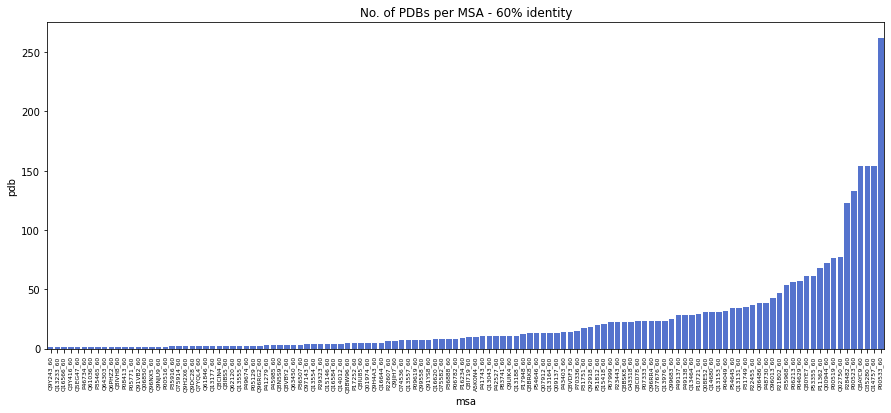

In [40]:
plt.figure(figsize= (15,6))
sns.barplot(data= msa_60_pdb_count, x= 'msa', y= 'pdb', color= 'royalblue')
#plt.rcParams['font.size'] = '14'
plt.xticks(fontsize= 6, rotation= 90)
plt.title("No. of PDBs per MSA - 60% identity")
plt.show()

---

### df with regions (KDs and CREs)  
for calculate regions MSAs using homology transfer pipeline

In [41]:
kinases = pd.read_csv('../datasets/kinases.tsv', sep= '\t')
kinases.columns = kinases.columns.str.lower().str.replace(" ", "_")
kinases = kinases.rename(columns= {'uniprot': 'uniprot_acc', 'cre_(start)': 'cre_start', 'cre_(end)': 'cre_end', 'kd_(start)': 'kd_start', 'kd_(end)': 'kd_end'})
kinases

,uniprot_acc,organism,cre_start,cre_end,cre_(s_or_d),length,kd_start,kd_end,pdb_id,pdb_res_(å),af,status
0,A0A2I0BVG8,P. falciparum (isolate NF54),346,353,no,NaN,56,325,no,no,AF-A0A2I0BVG8-F1,new
1,A0A509AFG4,P. berghei (strain Anka),385,393,no,NaN,110,365,no,no,AF-A0A509AFG4-F1,new
2,A0A509AHB6,P. berghei (strain Anka),345,352,no,NaN,57,324,no,no,AF-A0A509AHB6-F1,new
3,A0A509AKL0,P. berghei (strain Anka),1,33,no,NaN,545,802,no,no,AF-A0A509AKL0-F1,new
4,A0A509AQE6,P. berghei (strain Anka),394,402,no,NaN,118,372,no,no,AF-A0A509AQE6-F1,new
...,...,...,...,...,...,...,...,...,...,...,...,...
297,Q9ZSA4,A. thaliana,295,325,no,NaN,28,290,no,no,AF-Q9ZSA4-F1,new
298,Q9ZUZ2,A. thaliana,409,439,no,NaN,143,405,no,no,AF-Q9ZUZ2-F1,new
299,Q9ZV15,A. thaliana,398,428,no,NaN,134,392,no,no,AF-Q9ZV15-F1,new
300,W0LYS5,M. nipponense,287,327,no,NaN,31,287,no,no,AF-W0LYS5-F1,new


In [42]:
kd = kinases[['uniprot_acc', 'kd_start', 'kd_end']].drop_duplicates().rename(
    columns= {
        'kd_start': 'start',
        'kd_end': 'end'
    }
)
ids = [ "kd" + str(i) for i in range(1, len(kd)+1) ]
kd['term_id'] = ids
cre = kinases[['uniprot_acc', 'cre_start', 'cre_end']].drop_duplicates().rename(
    columns= {
        'cre_start': 'start',
        'cre_end': 'end'
    }
)
ids = [ "cre" + str(i) for i in range(1, len(cre)+1) ]
cre['term_id'] = ids

In [43]:
regions = pd.concat([kd, cre], ignore_index= True)

In [44]:
# kd.to_csv('../datasets/kd.tsv', sep= '\t', index= False)
# cre.to_csv('../datasets/cre.tsv', sep= '\t', index= False)
# regions.to_csv('../datasets/regions.txt', sep= '\t', index= False)

---

## mapear los PDB con las coord de KD y CRE

In [45]:
# Create PyRanges objects for joining them
# this is using the entire sift dataset
pdb = sift[['pdb', 'chain', 'sp_primary', 'sp_beg', 'sp_end']]
pdb_pr = pr.PyRanges(pdb.rename(
    columns= {
        'sp_primary': 'Chromosome',
        'sp_beg': 'Start',
        'sp_end': 'End'
    }
)
)
# this one is a subset of sift by our orthologs
# pdb_orthologs_pr = pr.PyRanges(pdb_orthologs.rename(
#     columns= {
#         'uniprot_acc': 'Chromosome',
#         'start': 'Start',
#         'end': 'End'
#     }
# )
# )

In [46]:
# Regions data as pyranges object
regions.columns = regions.columns.str.capitalize()
regions_pr = pr.PyRanges(regions.rename(columns= {'Uniprot_acc': 'Chromosome'}))

In [47]:
# Join both pdb and our regions coordinates
regions_pdb_join = regions_pr.join(pdb_pr, slack= 1, report_overlap= True)
regions_pdb_join = regions_pdb_join.as_df()
regions_pdb_join

,Chromosome,Start,End,Term_id,pdb,chain,Start_b,End_b,Overlap
0,A5K0N4,534,791,kd10,5fet,A,20,543,10
1,A5K0N4,534,791,kd10,4rz7,A,136,543,10
2,A5K0N4,534,791,kd10,5f0a,A,320,816,259
3,A5K0N4,534,791,kd10,5dzc,A,322,819,259
4,A5K0N4,534,791,kd10,5ezr,A,322,815,259
...,...,...,...,...,...,...,...,...,...
8352,Q99683,1,648,cre247,5ulm,A,384,444,60
8353,Q99683,1,648,cre247,5ulm,B,385,526,141
8354,Q99683,1,648,cre247,5ulm,A,448,526,78
8355,Q99683,1,648,cre247,5ulm,A,532,655,117


In [48]:
#regions_pr.join(pdb_orthologs_pr, report_overlap= True)

In [49]:
#del(pdb_orthologs_pr)

In [50]:
del(regions_pr, pdb_pr)

In [51]:
# control; check slack= 1
regions_pdb_join["length_region"] = regions_pdb_join.End - regions_pdb_join.Start + 2

In [52]:
regions_pdb_join.head(10)

,Chromosome,Start,End,Term_id,pdb,chain,Start_b,End_b,Overlap,length_region
0,A5K0N4,534,791,kd10,5fet,A,20,543,10,259
1,A5K0N4,534,791,kd10,4rz7,A,136,543,10,259
2,A5K0N4,534,791,kd10,5f0a,A,320,816,259,259
3,A5K0N4,534,791,kd10,5dzc,A,322,819,259,259
4,A5K0N4,534,791,kd10,5ezr,A,322,815,259,259
5,A5K0N4,534,791,kd10,5dyl,A,463,543,10,259
6,A5K0N4,534,791,kd10,5dyl,A,545,603,58,259
7,A5K0N4,534,791,kd10,5fet,A,546,603,57,259
8,A5K0N4,534,791,kd10,4rz7,A,546,571,25,259
9,A5K0N4,534,791,kd10,4rz7,A,576,815,216,259


In [53]:
#regions_pdb_join.describe()

In [54]:
#regions_pdb_join[regions_pdb_join.Overlap == 0]

In [55]:
#sift[sift.sp_end == sift.sp_beg]

---

## One example for conformational diversity

In [56]:
# # En que proteinas estan estos pdb?
# regions_pdb_join[regions_pdb_join.pdb == '2wel']

In [57]:
#regions_pdb_join[regions_pdb_join.pdb == '2vn9'] #Q13557

In [58]:
# # En que msa esta Q13557?
# our_example = all[all.reference == 'Q13557']
# our_example

In [59]:
#len(our_example.uniprot.values[0])

In [60]:
# # que otras estructuras hay en ese msa?
# our_pdb_examples = sift[sift.sp_primary.isin(our_example.uniprot.values[0])]
# our_pdb_examples # 2 proteins; 7 structures

In [61]:
#our_pdb_examples.pdb.unique()

In [62]:
# # cuales de esas estructuras comprenden el KD y el CRE?
# our_pdb_examples_pr = pr.PyRanges(
#     our_pdb_examples[['pdb', 'chain', 'sp_primary', 'sp_beg', 'sp_end']].rename(
#         columns= {
#             'sp_primary': 'Chromosome',
#             'sp_beg': 'Start',
#             'sp_end': 'End'
#         }
#     )
# )

In [63]:
# our_pdb_examples = our_pdb_examples_pr.join(regions_pr, report_overlap= True, suffix= "_region")
# our_pdb_examples = our_pdb_examples.as_df()
# our_pdb_examples # 2 proteins; 5 structures

In [64]:
#del(our_pdb_examples_pr)

In [65]:
#our_pdb_examples.pdb.unique()

In [66]:
# # Regions coordinates
# regions.query("Uniprot_acc == 'Q13557'")

In [67]:
#regions.query("Uniprot_acc == 'Q6PHZ2'")

In [68]:
# # Bring some AF structure of another protein in the alignment
# our_example.uniprot.values[0]

---

# PDBs

### PDBs covering entirely a region (CRE or KD)

In [69]:
regions_pdb_join

,Chromosome,Start,End,Term_id,pdb,chain,Start_b,End_b,Overlap,length_region
0,A5K0N4,534,791,kd10,5fet,A,20,543,10,259
1,A5K0N4,534,791,kd10,4rz7,A,136,543,10,259
2,A5K0N4,534,791,kd10,5f0a,A,320,816,259,259
3,A5K0N4,534,791,kd10,5dzc,A,322,819,259,259
4,A5K0N4,534,791,kd10,5ezr,A,322,815,259,259
...,...,...,...,...,...,...,...,...,...,...
8352,Q99683,1,648,cre247,5ulm,A,384,444,60,649
8353,Q99683,1,648,cre247,5ulm,B,385,526,141,649
8354,Q99683,1,648,cre247,5ulm,A,448,526,78,649
8355,Q99683,1,648,cre247,5ulm,A,532,655,117,649


In [70]:
# Filter those PDBs covering entirely a region (CRE or KD)
regions_pdb_covered = regions_pdb_join[regions_pdb_join.Overlap == regions_pdb_join.length_region]

In [71]:
regions_pdb_covered.pdb.nunique()

630

### How many PDBs cover both regions?

In [72]:
regions.sort_values("Uniprot_acc")

,Uniprot_acc,Start,End,Term_id
0,A0A2I0BVG8,56,325,kd1
286,A0A2I0BVG8,346,353,cre1
1,A0A509AFG4,110,365,kd2
287,A0A509AFG4,385,393,cre2
2,A0A509AHB6,57,324,kd3
...,...,...,...,...
283,Q9ZV15,134,392,kd284
570,W0LYS5,287,327,cre285
284,W0LYS5,31,287,kd285
285,W7JX98,541,798,kd286


In [73]:
# Horizontal table with KD y CRE regions coordinates
regions_h = kd.merge(cre, on= 'uniprot_acc', suffixes= ["_kd", "_cre"])
regions_h

,uniprot_acc,start_kd,end_kd,term_id_kd,start_cre,end_cre,term_id_cre
0,A0A2I0BVG8,56,325,kd1,346,353,cre1
1,A0A509AFG4,110,365,kd2,385,393,cre2
2,A0A509AHB6,57,324,kd3,345,352,cre3
3,A0A509AKL0,545,802,kd4,1,33,cre4
4,A0A509AQE6,118,372,kd5,394,402,cre5
...,...,...,...,...,...,...,...
288,Q9ZSA4,28,290,kd282,295,325,cre282
289,Q9ZUZ2,143,405,kd283,409,439,cre283
290,Q9ZV15,134,392,kd284,398,428,cre284
291,W0LYS5,31,287,kd285,287,327,cre285


In [74]:
# Regions "global range", start and end including both KD and CRE
regions_gl = regions_h[['uniprot_acc', 'term_id_kd', 'term_id_cre']].copy()
regions_gl["start"] = regions_gl['end'] = 0
for i in regions_h.index:
    coords = [regions_h.start_cre[i], regions_h.end_cre[i], regions_h.start_kd[i], regions_h.end_kd[i]]
    start = min(coords)
    end = max(coords)
    regions_gl['start'][i] = start
    regions_gl['end'][i] = end

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [75]:
regions_gl.rename(columns= {'uniprot_acc': 'Chromosome' }, inplace= True)
regions_gl.columns = regions_gl.columns.str.capitalize()
regions_gl["length"] = regions_gl.End - regions_gl.Start

In [76]:
# As pyranges object
regions_gl_pr = pr.PyRanges(regions_gl)

In [77]:
pdb = sift[['pdb', 'chain', 'sp_primary', 'sp_beg', 'sp_end']]

In [78]:
pdb_pr = pr.PyRanges(pdb.rename(
    columns= {
        'sp_primary': 'Chromosome',
        'sp_beg': 'Start',
        'sp_end': 'End'
    }
)
)

In [79]:
regions_gl_pr = regions_gl_pr.join(pdb_pr, slack= 1, report_overlap= True)
regions_pdb_both = regions_gl_pr.as_df()
regions_pdb_both.columns = regions_pdb_both.columns.str.lower()
regions_pdb_both.rename(columns= {'chromosome': 'uniprot'}, inplace= True)
regions_pdb_both

,uniprot,term_id_kd,term_id_cre,start,end,length,pdb,chain,start_b,end_b,overlap
0,A5K0N4,kd10,cre10,1,791,790,4rz7,A,1,13,12
1,A5K0N4,kd10,cre10,1,791,790,5dyl,A,1,5,4
2,A5K0N4,kd10,cre10,1,791,790,5dzc,A,1,5,4
3,A5K0N4,kd10,cre10,1,791,790,5f0a,A,1,5,4
4,A5K0N4,kd10,cre10,1,791,790,5ezr,A,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...
8022,Q99683,kd247,cre247,1,938,937,5v19,A,889,939,50
8023,Q99683,kd247,cre247,1,938,937,6oyt,B,889,939,50
8024,Q99683,kd247,cre247,1,938,937,5uor,A,890,939,49
8025,Q99683,kd247,cre247,1,938,937,6oyt,A,899,939,40


,uniprot,term_id_kd,term_id_cre,start,end,length,pdb,chain,start_b,end_b,overlap
0,A5K0N4,kd10,cre10,1,791,790,4rz7,A,1,13,12
1,A5K0N4,kd10,cre10,1,791,790,5dyl,A,1,5,4
2,A5K0N4,kd10,cre10,1,791,790,5dzc,A,1,5,4
3,A5K0N4,kd10,cre10,1,791,790,5f0a,A,1,5,4
4,A5K0N4,kd10,cre10,1,791,790,5ezr,A,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...
8022,Q99683,kd247,cre247,1,938,937,5v19,A,889,939,50
8023,Q99683,kd247,cre247,1,938,937,6oyt,B,889,939,50
8024,Q99683,kd247,cre247,1,938,937,5uor,A,890,939,49
8025,Q99683,kd247,cre247,1,938,937,6oyt,A,899,939,40


In [112]:
regions_pdb_both.pdb.nunique()

1904

In [113]:
regions_pdb_both[regions_pdb_both.pdb == '2ltu']

,uniprot,term_id_kd,term_id_cre,start,end,length,pdb,chain,start_b,end_b,overlap
6204,P54646,kd100,cre100,16,376,360,2ltu,A,282,339,57


In [114]:
sift[['pdb', 'chain', 'sp_primary', 'sp_beg', 'sp_end']]

,pdb,chain,sp_primary,sp_beg,sp_end
0,121p,A,P01112,1,166
1,132l,A,P00698,19,147
2,133l,A,P61626,19,148
3,129l,A,P00720,1,162
4,139l,A,P00720,1,162
...,...,...,...,...,...
977668,6e9d,v,P03135,226,735
977669,6e9d,w,P03135,226,735
977670,6e9d,x,P03135,226,735
977671,6e9d,y,P03135,226,735


In [74]:
del(regions_gl_pr, pdb_pr)

In [75]:
regions_pdb_both.pdb.nunique()

1904

---

In [76]:
to_merge = regions_pdb_both[['uniprot', 'pdb', 'start_b', 'end_b']]
to_merge = to_merge.rename(columns= {'start_b': 'start', 'end_b': 'end'})
to_merge

,uniprot,pdb,start,end
0,A5K0N4,4rz7,1,13
1,A5K0N4,5dyl,1,5
2,A5K0N4,5dzc,1,5
3,A5K0N4,5f0a,1,5
4,A5K0N4,5ezr,2,5
...,...,...,...,...
8022,Q99683,5v19,889,939
8023,Q99683,6oyt,889,939
8024,Q99683,5uor,890,939
8025,Q99683,6oyt,899,939


In [104]:
#to_merge.groupby("uniprot").agg({'pdb': lambda x: x.tolist()}).reset_index()

In [105]:
msa_pdb = all_msas.merge(to_merge)
msa_pdb = msa_pdb[['msa', 'uniprot', 'pdb', 'length_msa']].drop_duplicates()
msa_pdb

,msa,uniprot,pdb,length_msa
0,Q8C078_60,Q96RR4,5yv8,843
1,Q8C078_60,Q96RR4,5yvb,843
2,Q8C078_60,Q96RR4,5yvc,843
3,Q8C078_60,Q96RR4,5yva,843
4,Q8C078_60,Q96RR4,5yv9,843
...,...,...,...,...
29109,P04629_80,P04629,6j5l,822
29110,P04629_80,P04629,4yps,822
29240,Q13554_60,Q13554,3bhh,822
29248,Q13554_80,Q13554,3bhh,701


In [106]:
msa_pdb.pdb.nunique()

1822

In [107]:
#msa_pdb.to_csv('../datasets/msa_pdb.tsv', sep='\t', index= False)

In [108]:
# Keep unique PDBs and filter by 60% identity MSAs
msa_pdb_60 = msa_pdb[msa_pdb.msa.str.endswith("60")]
#msa_pdb_60 = msa_pdb_60[['msa', 'uniprot', 'pdb']].drop_duplicates()
msa_pdb_60

,msa,uniprot,pdb,length_msa
0,Q8C078_60,Q96RR4,5yv8,843
1,Q8C078_60,Q96RR4,5yvb,843
2,Q8C078_60,Q96RR4,5yvc,843
3,Q8C078_60,Q96RR4,5yva,843
4,Q8C078_60,Q96RR4,5yv9,843
...,...,...,...,...
28690,P04629_60,P04629,4yne,822
28691,P04629_60,P04629,6iqn,822
28693,P04629_60,P04629,6j5l,822
28694,P04629_60,P04629,4yps,822


In [109]:
msa_pdb_60.pdb.nunique()

1820

In [115]:
# Copy those .pdb files to specific path
import os, shutil
import requests

proxies = {
    'http': 'http://proxy.leloir.org.ar:3128',
    'https': 'http://proxy.leloir.org.ar:3128'
}

# First, create a list and populate it with the pdb files
pdbs_to_find = msa_pdb_60.pdb.to_list()

# # path containing all pdbs files
# path = "../datasets/kinases_cre_pdb_files/"
# dirs = os.listdir(path)

# # This would print all the files and directories
# for file in dirs:
#     print(file)
#     if file in pdbs_to_find:
#         print(f"{file} is in list")
#         shutil.copy(path + "/" + file, '../datasets/pdb_files_60/')

#DESCARGAR
error = {}
already = []
for pdb in pdbs_to_find:
    r = requests.get("https://files.rcsb.org/download/" + pdb + ".pdb", proxies= proxies)
    if r.status_code == 200:
        text_resp = r.text

        f = open("../datasets/pdb_files_60/" + pdb + ".pdb", "w")
        f.write(text_resp)
        f.close()

        already.append(pdb)
        print(f"saved: {pdb}")
    else:
        error[pdb] = r.status_code
        print(f"error: {pdb}")

saved: 5yv8
saved: 5yvb
saved: 5yvc
saved: 5yva
saved: 5yv9
saved: 2zv2
saved: 5uy6
saved: 5uyj
saved: 6bql
saved: 6cmj
saved: 5vt1
saved: 6ble
saved: 6brc
saved: 6bqp
saved: 6bqq
saved: 6bku
saved: 5yv8
saved: 5yvb
saved: 5yvc
saved: 5yva
saved: 5yv9
saved: 2zv2
saved: 5uy6
saved: 5uyj
saved: 6bql
saved: 6cmj
saved: 5vt1
saved: 6ble
saved: 6brc
saved: 6bqp
saved: 6bqq
saved: 6bku
saved: 7myj
saved: 3aqv
saved: 6b1u
saved: 4cff
saved: 4cfe
saved: 5iso
saved: 6b2e
saved: 4zhx
saved: 2h6d
saved: 2yza
saved: 6bx6
saved: 5ezv
saved: 2ltu
saved: 7myj
saved: 3aqv
saved: 6b1u
saved: 4cff
saved: 4cfe
saved: 5iso
saved: 6b2e
saved: 4zhx
saved: 2h6d
saved: 2yza
saved: 6bx6
saved: 5ezv
saved: 2ltu
saved: 7myj
saved: 3aqv
saved: 6b1u
saved: 4cff
saved: 4cfe
saved: 5iso
saved: 6b2e
saved: 4zhx
saved: 2h6d
saved: 2yza
saved: 6bx6
saved: 5ezv
saved: 2ltu
saved: 3omv
error: 7z37
saved: 7z38
saved: 3com
saved: 6yat
saved: 8a5j
saved: 5twg
saved: 5twh
saved: 7cec
saved: 7ceb
saved: 7cea
saved: 7qid
save

In [116]:
error

{'7z37': 404,
 '7ozb': 404,
 '7ozd': 404,
 '7ozf': 404,
 '6t28': 404,
 '6t29': 404,
 '6z1q': 404,
 '6z1t': 404,
 '7pus': 404,
 '7ozy': 404}

In [82]:
msa_size = msa_pdb.groupby('msa')['pdb'].size().to_frame().reset_index().rename(columns= {'pdb': 'no_pdb'})
msa_list = msa_pdb.groupby('msa').agg({'pdb': lambda x: x.tolist()}).reset_index()

In [83]:
msa_pdb_distrib = msa_list.merge(msa_size).sort_values('no_pdb')
msa_pdb_distrib

,msa,pdb,no_pdb
242,Q5EG47_60,[5ufu],1
107,P35465_all,[1e0a],1
346,Q9NJU9_all,[3k21],1
345,Q9NJU9_80,[3k21],1
344,Q9NJU9_60,[3k21],1
...,...,...,...
36,P00523_80,"[7a3c, 7a3c, 7a3c, 7ner, 7a3c, 6xvm, 6xvm, 7a3...",869
37,P00523_all,"[7a3c, 7a3c, 7a3c, 7ner, 7a3c, 6xvm, 6xvm, 7a3...",869
38,P00533_60,"[1z9i, 3gop, 4rix, 4riy, 4riw, 4rix, 4riy, 4ri...",881
39,P00533_80,"[1z9i, 3gop, 4rix, 4riy, 4riw, 4rix, 4riy, 4ri...",881


In [84]:
msa_pdb_distrib.pdb = msa_pdb_distrib.pdb.apply(lambda x: list(set(x)))
msa_pdb_distrib.no_pdb = msa_pdb_distrib.pdb.apply(lambda x: len(x))
msa_pdb_distrib

,msa,pdb,no_pdb
242,Q5EG47_60,[5ufu],1
107,P35465_all,[1e0a],1
346,Q9NJU9_all,[3k21],1
345,Q9NJU9_80,[3k21],1
344,Q9NJU9_60,[3k21],1
...,...,...,...
36,P00523_80,"[7net, 4u5j, 7a3e, 5ob1, 4jz3, 7a3d, 6xx2, 3lo...",133
37,P00523_all,"[7net, 4u5j, 7a3e, 5ob1, 4jz3, 7a3d, 6xx2, 3lo...",133
38,P00533_60,"[4hjo, 5xgn, 1m17, 4zse, 5x26, 7b85, 2itz, 5ca...",216
39,P00533_80,"[4hjo, 5xgn, 1m17, 4zse, 5x26, 7b85, 2itz, 5ca...",216


In [85]:
import seaborn as sns

In [86]:
#sns.barplot(data= msa_pdb_distrib, x= 'msa', y= 'no_pdb')

In [87]:
#msa_pdb_distrib_60.to_csv('../datasets/msa_pdb_distrib_60.tsv', sep= '\t', index= False)

[]

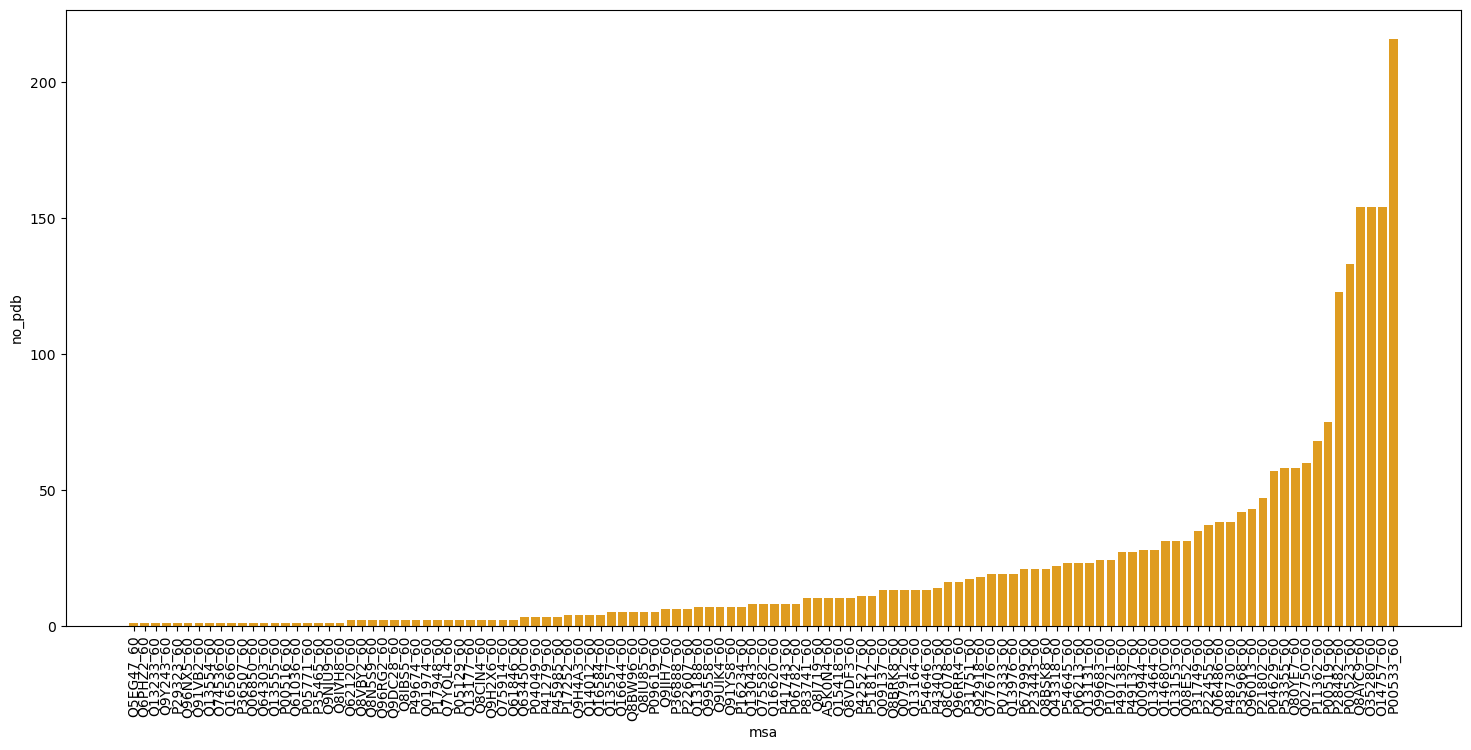

In [88]:
msa_pdb_distrib_60 = msa_pdb_distrib[msa_pdb_distrib.msa.str.endswith("_60")].sort_values("no_pdb")
plt.figure(figsize= (18,8))
sns.barplot(data= msa_pdb_distrib_60, x= 'msa', y= 'no_pdb', color= 'orange')
plt.xticks(rotation= 90)
plt.plot()

<AxesSubplot:>

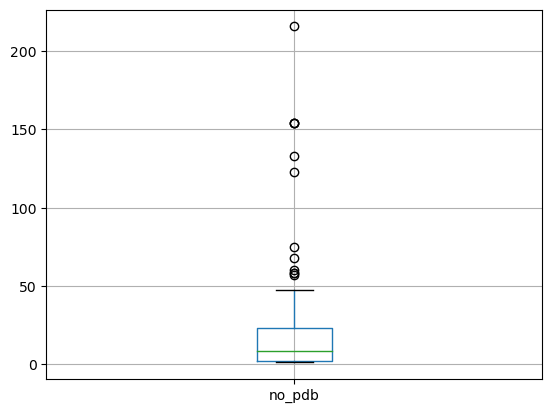

In [89]:
msa_pdb_distrib_60.boxplot()

---

### pruebas

In [90]:
# ortho_uniprot = pd.read_csv('../raw_data/orthologs-uniprot-structure-2022.11.18-20.00.24.25.tsv.gz', sep= '\t', compression= 'gzip')
# ortho_uniprot.info()

In [91]:
#mapping_uniprot_pdb = pd.read_csv('../raw_data/orthologs-uniprot-pdb-mapping-compressed-2022.11.22-16.55.31.52.tsv.gz', sep= '\t', compression= 'gzip')

In [92]:
#mapping_uniprot_pdb.To.nunique()

In [93]:
#mapping_uniprot_pdb.From.nunique()

In [97]:
# Q8C078_60 = msa_pdb[msa_pdb.uniprot == 'Q96RR4'][['msa' ,'uniprot', 'pdb']].drop_duplicates()
# Q8C078_60

In [98]:
#regions[regions.Uniprot_acc == 'Q96RR4']

In [99]:
#sift[sift.sp_primary == 'Q96RR4']